<div style="display: flex; align-items: center;">
  <h1 style="font-size: 4.5em; margin-right: 15px;">Physics Aware Recurrent Convolutional Neural Network (PARC): Shear-Flow Demo</h1>
  <div>
    <img src="../misc/VIL_logo.png" width="190" alt="Image 1" style="margin-right: 1px;" />
    <img src="../misc/uva.png" width="190" alt="Image 2" style="margin-right: 1px;" />
    <img src="../misc/iowa.png" width="190" alt="Image 3" />
  </div>
</div>
<p>A customizable framework to embed physics in Deep Learning. PARC's formulation is inspired by Advection-Diffusion-Reaction processes and uses an Inductive Bias approach to constrain the Neural Network.</p>




## Why PARC?
<p>PARC brings together deep learning with first prinicples physics - its recurrent convolutional core is able to learn complex spatiotemporal patterns, while built-in biases (conservation laws & advection-diffusion operators) ensure every prediction is physically plausible. PARC is constructed in such a manner that is does not need to "re-learn" fundemental dynamics - allowing faster training with far less data.</p>

<p>PINN (Physics-Informed Neural Networks) exists as an adjacent model to PARC. While PINN may preform decently on generics, it struggles with advection or chaotic/non-linear systems - net leading to higher computational cost. In such situations PARC is deemed the superior model with it being more scalable, efficient, and accurate than other physics-based models.</p>

### Goal
<p>The goal of this notebook is to walk you through the use cases of PARC via 2D periodic incompressible Shear-Flow. At the end of this notebook you will be presented with visualization in accordance to the equations representing conservation of momentum for fluids and fully describing fluid motion.</p>

The notebook will guide you through from start to finish in preparing, training, and modeling a physics-based equation. The notebook will cover the following:

- loading and preparing data for Shear-Flow
- Using PARCv2 Model to learn and predict time evolution of $u(x,t)$
- Evaluating the model's preformance and compare predicted resutls to ground truth

### Internal General PARC PDE
<p>Below is the general form of the partial differential equation that PARCv2 is learning - and its inital boundaries. In the case of 2D periodic incompressible Shear-Flow - we can describe the certain vairables to represent the nessearcy points in which PARC tries to model after the equation.</p>

$$
\frac{\partial X}{\partial t} = f(X,\mu) + \epsilon
$$

- $X$ is the fields of interest - Temperature, Pressure, Reynolds, Velocities (U & V)
- $μ$ is the microstructure


### Setting Up
<p>This document serves as a guide to training a PARC model for 2D periodic incompressible Shear-Flow. Here are the inital steps to take before you begin training your PARC model!<p>

{} -> need to figure out setup instructions for the public

## Compute Data Normalization

In [1]:
import sys
import os
from pathlib import Path
from PARCtorch.data.normalization import compute_min_max

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Define data directowies
train_dir = Path("/standard/sds_baek_energetic/data/physics/the_well/datasets/shear_flow/data/train")
test_dir = Path("/standard/sds_baek_energetic/data/physics/the_well/datasets/shear_flow/data/test")

## Data Loader for Training
<p> We next create a <strong>DataLoader</strong> for training. The DataLoader in PyTorch is a crucial utility that facilitates efficient data handling for training and evaluating machine learning models. It abstracts the process of fetching, batching, and shuffling data, ensuring that the model is fed with properly formatted inputs in an optimal way. Specifically, it helps with:</p>

<ul>
    <li><strong>Batching:</strong> Splitting large datasets into smaller, manageable batches to avoid memory overload and enable parallel processing.</li>
    <li><strong>Shuffling:</strong> Randomly ordering data to prevent the model from learning patterns related to the sequence of data (particularly important in training to reduce overfitting).</li>
    <li><strong>Parallel Loading:</strong> It allows the data to be loaded asynchronously using multiple workers, speeding up the training process by loading the next batch while the current one is being processed by the model.</li>
    <li><strong>Custom Collation:</strong> The <code>collate_fn</code> allows customization of how batches are combined, which is essential for complex datasets that require specific handling.</li>
</ul>


In [2]:
import PARCtorch.data.dataset as ds_mod

# override the __del__ so it never tries to iterate that missing attr
ds_mod.WellDatasetInterface.__del__ = lambda self: None

# Now import the utilities
from PARCtorch.data.dataset import WellDatasetInterface
from the_well.data.datasets import WellDataset
from torch.utils.data import DataLoader
import torch

# Now import the utilities
from PARCtorch.data.dataset import (
    WellDatasetInterface,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from PARCtorch.utilities.viz import (
    visualize_channels,
    save_gifs_with_ground_truth,
)
future_steps = 1
batch_size = 3

# Initialize the dataset
ds = WellDatasetInterface(
        future_steps=future_steps,
        well_dataset_args={
            "well_base_path": "/standard/sds_baek_energetic/data/physics/the_well/datasets/",
            "well_dataset_name": "shear_flow",
            "well_split_name": "train",
            "exclude_filters": ["shear_flow_Reynolds_5e5_Schmidt_1e0.hdf5"]
        }
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    collate_fn=custom_collate_fn,
)

## Visualize the Data - Check it was Loaded Properly
<p> We are now going to visualize our data to verify if the correct data is loading and formatting. In the cell below we are iterating over the previously defined DataLoader and fetching one batch of data. The batch is then split up into the following variables:</p>

<ul>
    <li><code>ic</code>: Inital conditions - the initial state of the physical system</li>
    <li><code>t0</code>: Starting time-step </li>
    <li><code>t1</code>: Ending time-step </li>
    <li><code>target</code>: Ground truth future states</li>
</ul>




Channel Data Statistics:
Channel 0: IC min=10000.0, IC max=10000.0
  Step 1: min=10000.0, max=10000.0
Channel 1: IC min=0.10000000149011612, IC max=0.10000000149011612
  Step 1: min=0.10000000149011612, max=0.10000000149011612
Channel 2: IC min=-0.5, IC max=0.5
  Step 1: min=-0.5, max=0.5
Channel 3: IC min=0.0, IC max=0.0
  Step 1: min=-0.02280947007238865, max=0.021170886233448982
Channel 4: IC min=-0.5, IC max=0.5
  Step 1: min=-0.5113672614097595, max=0.5106528401374817
Channel 5: IC min=-0.0992525964975357, IC max=0.0992525964975357
  Step 1: min=-0.03139960765838623, max=0.03140629082918167


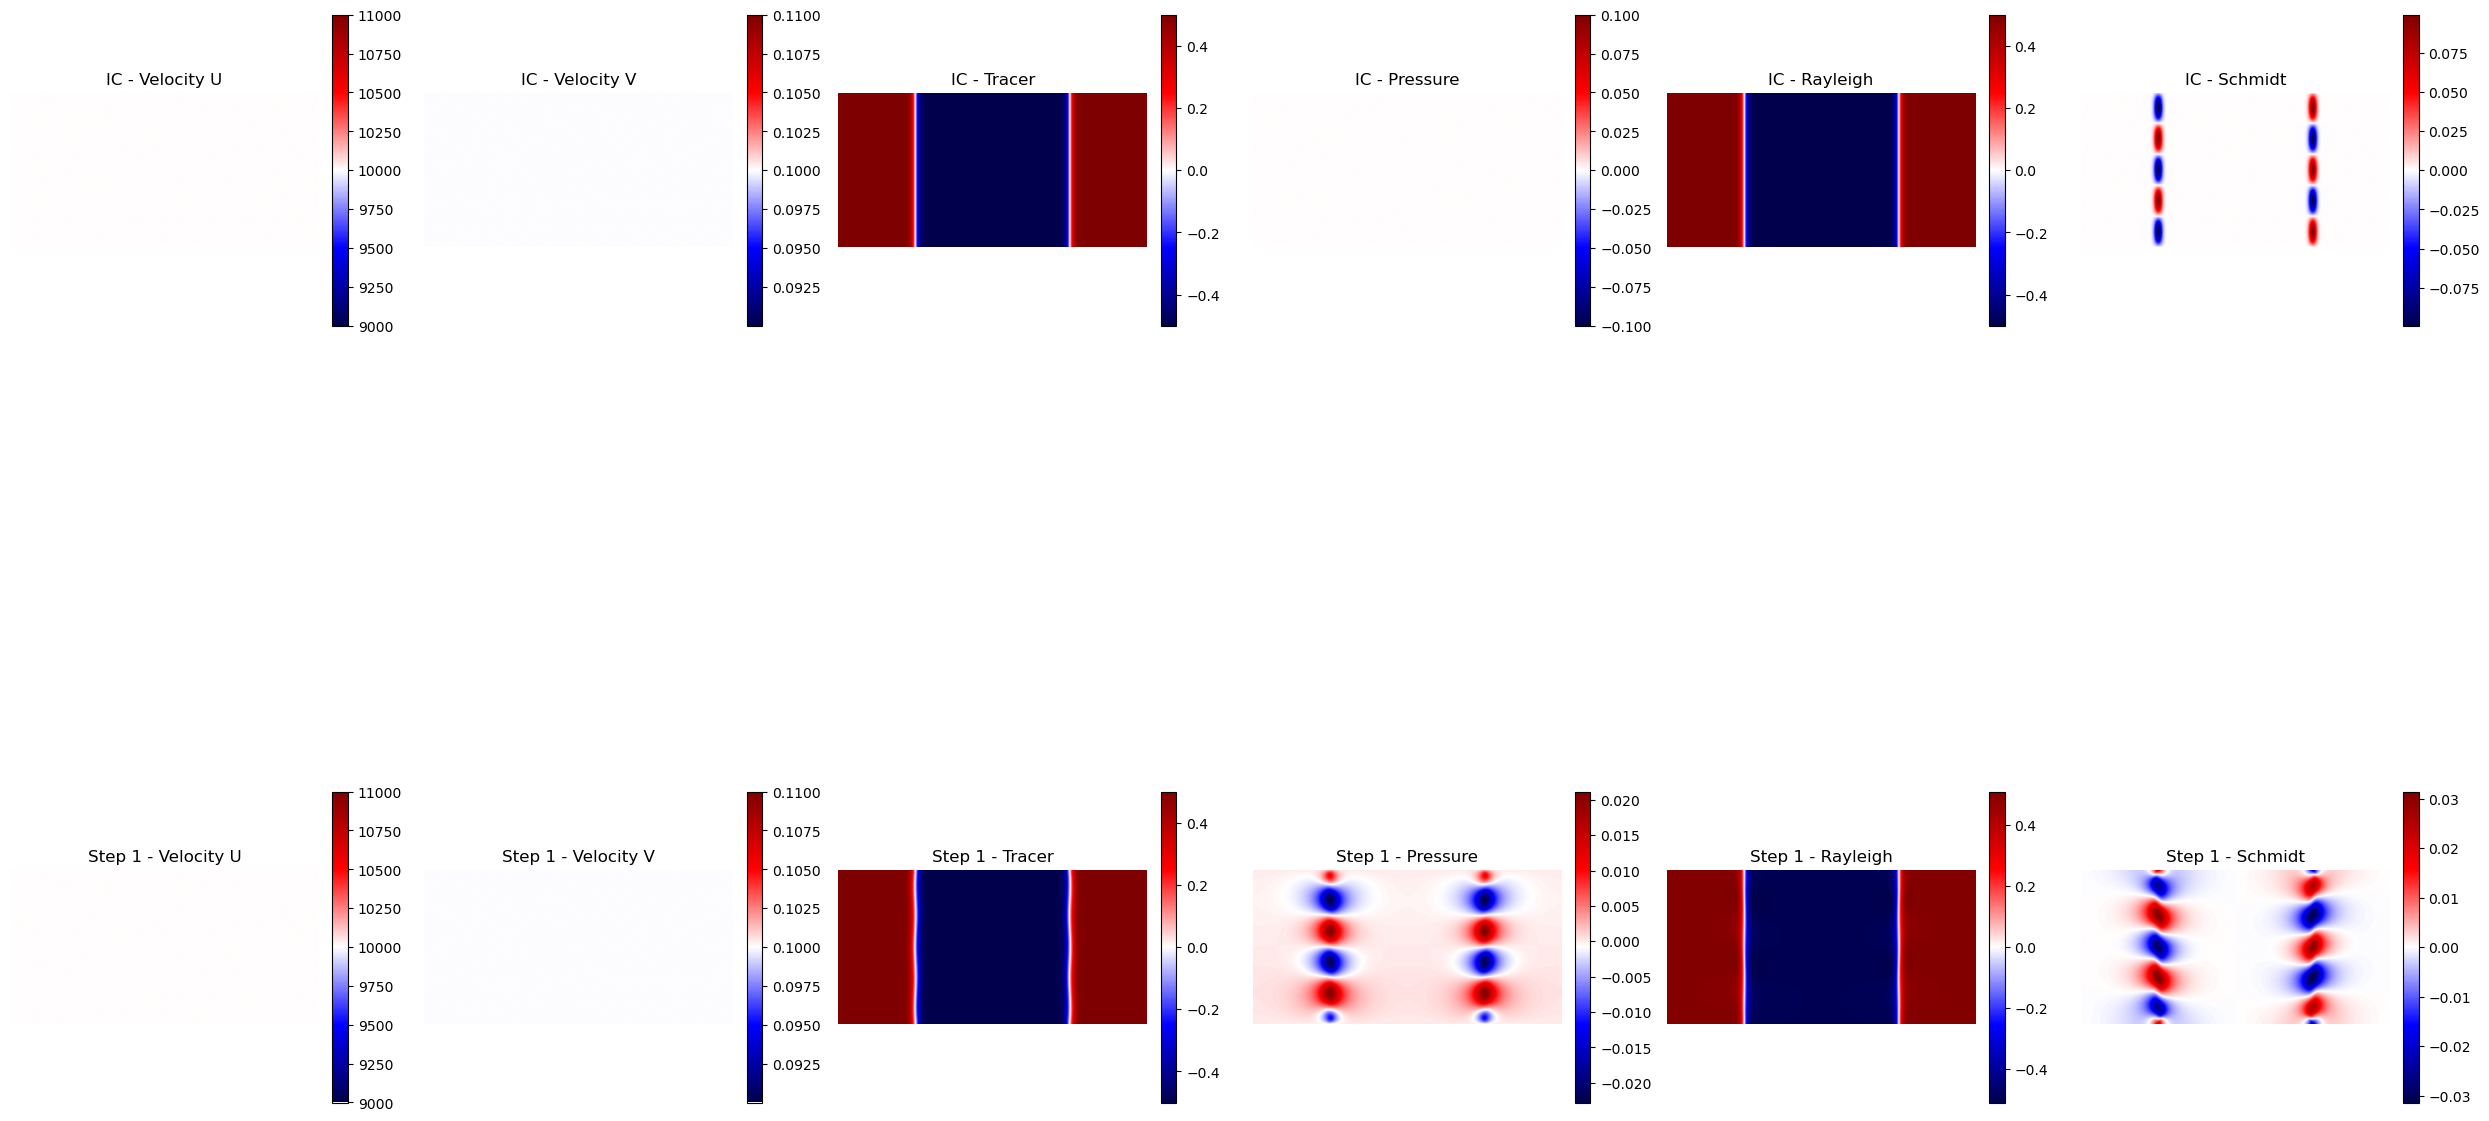

In [3]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = [
        "Velocity U",
        "Velocity V",
        "Tracer",
        "Pressure",
        "Rayleigh",
        "Schmidt",
    ]
    custom_cmaps = ["seismic", "seismic", "seismic", "seismic", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

<h2>Build Your PARC Model</h2>
<p>In this section, we are constructing a <strong>PARCv2 model</strong>, which is designed to handle spatiotemporal data, such as fluid dynamics simulations. The model leverages various components, including <em>differentiators</em> and <em>integrators</em>, to solve physical equations like 2D periodic incompressible Shear-Flow.</p>

<p><strong>Key Components:</strong></p>
<ul>
    <li><strong>UNet:</strong> The UNet architecture is used for feature extraction, transforming the input data into a higher-dimensional representation. This helps the model capture complex patterns in the physical simulation data.</li>
    <li><strong>FiniteDifference:</strong> This differentiator approximates the gradients (or derivatives) of the input data using a finite difference method, which is important for calculating advection and diffusion processes in fluid dynamics.</li>
    <li><strong>Heun Integrator:</strong> Heun’s method is an improved version of Euler's method, used here to integrate the equations of motion more accurately over time.</li>
    <li><strong>Differentiator:</strong> This module calculates the advection and diffusion terms based on specific channel indices, such as velocity in the x and y directions (u and v).</li>
    <li><strong>Integrator:</strong> The integrator applies Heun’s method to combine the differentiated terms and solve the Poisson equation, ensuring the physical constraints of the system are respected.</li>
</ul>

<p>The model is then wrapped into the <strong>PARCv2</strong> class, which combines the differentiator, integrator, and loss function (<code>L1Loss</code>). Finally, an <code>Adam</code> optimizer is initialized to train the model by adjusting its parameters to minimize the error between predictions and ground truth data.</p>

<p>This setup allows the model to learn how to predict future states in complex physical systems by embedding domain-specific knowledge.</p>


In [4]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import ADRDifferentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

from torch.optim import Adam

In [6]:
# Defining Navier-Stokes 2D Imcompressible Shear Flow

PARCv2.check = lambda self: True # temp - for no attr named check in PARCv2
PARCv2.check_msg = lambda self, chk: None # temp - has no attribute named check_msg

n_fe_features = 64  # Number of features extracted by the UNet
# Initialize the UNet architecture for feature extraction
unet_sf = UNet(
    [64, 64 * 2, 64 * 4],  
    6, 
    n_fe_features,
    3,
    "zeros",
    up_block_use_concat=[False, True],  
    skip_connection_indices=[0],  
)

# Initialize finite difference method for numerical differentiation
right_diff = FiniteDifference(padding_mode="replicate").cuda()  # Use replication padding to handle boundary conditions

# Initialize Heun's method for numerical integration
heun_int = Heun().cuda() 

# Create the Differentiator, responsible for calculating advection and diffusion
diff_sf = ADRDifferentiator(
    4,  
    n_fe_features,  
    [0, 1, 2, 3, 4, 5],  
    [0, 1, 2, 3, 4, 5],  
    unet_sf,  
    "constant",  
    right_diff,  
    False 
).cuda()

# Create the Integrator, responsible for solving the Poisson equation and performing integration
sf_int = Integrator(
    True,  
    [],  
    heun_int,  
    [None, None, None, None],  
    "constant",  
    right_diff,
    3, 
    64
).cuda()

# Define the loss function (L1 Loss is typically used for regression tasks)
criterion = torch.nn.L1Loss().cuda()

# Initialize the PARCv2 model with the differentiator, integrator, and loss function
model = PARCv2(diff_sf, sf_int, criterion).cuda()

# Set up the optimizer (Adam is a popular choice for adaptive learning rate optimization)
optimizer = Adam(model.parameters(), lr=1e-5)  


## Train the Model 
<p>Now, we will be training the PARC model using the training data and the paramaters we have setup above. Here we iterate over the dataset given by <code>train_loader</code> batch-by-batch and in each iteration we: </p>

<ul>
    <li>Compute model predictions</li>
    <li>Calculate error loss between predictions and ground truth values via the <code>criterion</code> loss function </li>
    <li>Update the model parameters based on error via the <code>optimizer</code></li>
</ul>



In [7]:
from PARCtorch.train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=1,
    save_dir=train_dir.parent,
    app="ns",
)


Epoch 1/1:   0%|          | 0/46699 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 44.43 GiB of which 15.69 MiB is free. Process 337117 has 36.24 GiB memory in use. Including non-PyTorch memory, this process has 8.05 GiB memory in use. Of the allocated memory 7.70 GiB is allocated by PyTorch, and 51.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Load the Model
<p> Post training, we can now load the previously trained model weights into our PARC model for evalutation. Here, we locate the model weights and load them into the exisiting PARC model architecture in order to prep for visualization.</p>

In [ ]:
from PARCtorch.utilities.load import load_model_weights

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = (
    train_dir.parent / "model.pth"  # Replace with your path
)
model = load_model_weights(model, model_weights_path, device)

## Sequence DataLoader
<p>We now create a sequence DataLoader designed to test the dataset - providing the initial conditions as <code>t=0</code> for generating predictiond over multiple timesteps. Using <code>DataLoader</code> we wrap the dataset for efficent batching and processing.</p>

<p>We also create the Initial Condition Dataset, which loades the initial state for the physical system, the previously computed normalization parameters, and prepares the dataset to be fed into the model. We also 

In [ ]:
# Initialize the dataset
future_steps = 10
seq_dataset = InitialConditionDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

## Ground Truth Loader
<p>Here, we set up the Ground Truth Loader to provide a comparison of the actual future states of the system against the models predictions. Similar set up to previous <code>DataLoader</code> setups in this notebook.</p>

In [ ]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

## Visualize the Results
<p> We now finially visualize our results. Here, we run inferences using thr trained PARC model's predictions against the ground truth. Visualization gifs of the predictions and ground truth are outputted - just runs on the first batch for demo.</p>

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["pressure", "Reynolds", "u", "v"]  # Adjust as per your data
cmaps = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset